In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display
import glob as glob

from utils.diagnostics import compute_summary_statistics
from utils.dataset_utils import aggregate_results

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

In [13]:
model_names = ["ew_lo_small", "dlpo_ls_small", "mvo_ls_small_mle_mle"]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]

In [14]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        summary = aggregate_results(path=output_path)

        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["model"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

## 1) Summary Statistics of the Portfolios

In [15]:

all_stats = {}
for model in model_names:

    portfolio_returns = torch.tensor(all_summary_df.loc[all_summary_df["model"] == model].groupby("date").sum()["pnl"])
    stats = compute_summary_statistics(portfolio_returns=portfolio_returns)

    all_stats[model] = stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

display(HTML(all_stats_df.to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
ew_lo_small,12.598263,19.314000,0.652287,0.746558,-3.669391,-40.195822,0.521073
dlpo_ls_small,1.923000,8.730236,0.220269,0.293952,-3.286616,-11.182754,0.507477
mvo_ls_small_mle_mle,-33.271902,26.094108,-1.275073,-1.365929,-42.621211,-80.051893,0.476636


In [16]:
print(all_stats_df.reset_index().to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
               index &       E[R] &    Std(R) &    Sharpe &   Sortino &      AvgDD &      MaxDD &  \% Positive Ret. \\
\midrule
         ew\_lo\_small &  12.598263 & 19.314000 &  0.652287 &  0.746558 &  -3.669391 & -40.195822 &         0.521073 \\
       dlpo\_ls\_small &   1.923000 &  8.730236 &  0.220269 &  0.293952 &  -3.286616 & -11.182754 &         0.507477 \\
mvo\_ls\_small\_mle\_mle & -33.271902 & 26.094108 & -1.275073 & -1.365929 & -42.621211 & -80.051893 &         0.476636 \\
\bottomrule
\end{tabular}



## 2) Cummulative Returns of the Portfolios

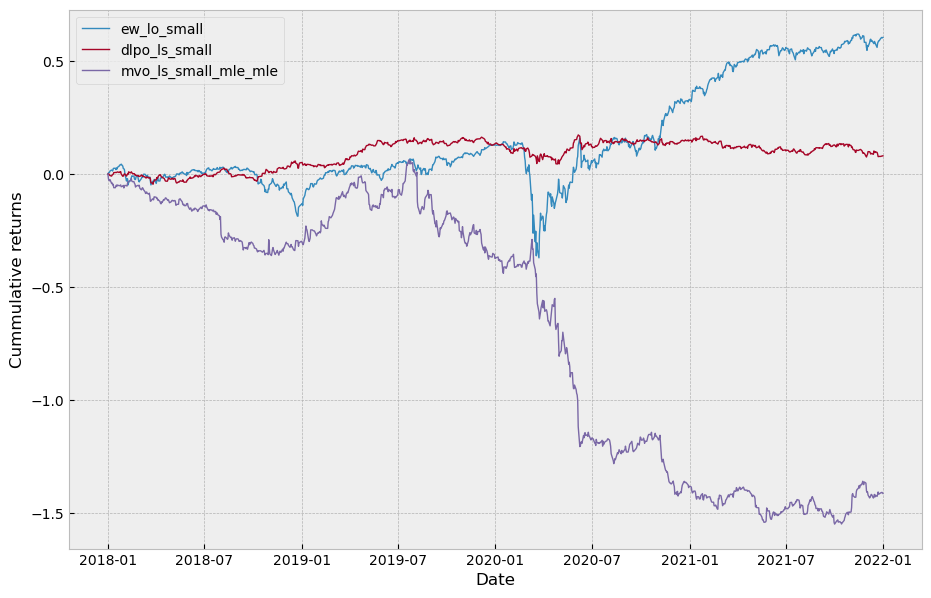

In [18]:

fig, ax = plt.subplots(figsize=(11, 7))
for model in model_names:
    summary_df = all_summary_df.loc[all_summary_df["model"] == model]
    cum_pnl_df = summary_df.groupby("date").sum()[["pnl"]].loc["2018-01-01":].cumsum().reset_index()
    ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

plt.xlabel("Date")
plt.ylabel("Cummulative returns")
plt.legend(loc='best', fontsize=10)   
# fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
plt.show()

## 3) Boxplot with the Sharpe Ratio for each Monte Carlo Sample

## 4) Forecast Comparison - Diebold-Mariano Test